In [9]:
%run ../common_utils.py

# Import Data

In [10]:
train, test, metadata = load_all_data()

In [11]:
nonCategorical, categorical = get_cat_and_non_cat_data(metadata)
categorical.remove('district')
all_features = list(train.columns)
all_features.remove('price')
numerical_features = ['area_total','area_kitchen','area_living','floor','rooms','ceiling',
    'bathrooms_shared','bathrooms_private','balconies','loggias','phones','building_id','constructed','stories']

In [12]:
categorical_to_numerical(train, ['street','address'])
categorical_to_numerical(test, ['street','address'])

In [13]:
%%capture --no-display
X_train, y_train, X_test, y_test, test_labels = pre_process_numerical(features = all_features, Numerical_features = numerical_features, train = train, test = test,
                    outliers_value=7, val_split=0.2, random_state=42, scaler="std",
                    add_R="True", add_rel_height="True", droptable=[],
                    one_hot_encode=True, cat_features=categorical, drop_old=True)

# Load Models

## Imports for models

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm
from catboost import CatBoostRegressor
from sklearn import metrics


## Imports for plots

In [35]:
import seaborn as sns

In [19]:
catboost = CatBoostRegressor(
    loss_function=metrics.mean_squared_log_error,
    eval_metric=metrics.mean_squared_log_error,
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [16]:
light_gbm = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [17]:
grad_boost_regr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

# Metrics

In [23]:
metrics.mean_squared_log_error

<function sklearn.metrics._regression.mean_squared_log_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>

In [159]:
# catboost.fit(X_train, y_train)

In [209]:
# def custom_asymmetric_objective(y_true, y_pred):
#     grad = np.where(y_pred <y_true, -1/(y_pred + 1), 1/(y_pred + 1))
#     hess = np.where(y_pred <y_true, 1/(y_pred + 1)**2, 1/(y_pred + 1)**2)
#     return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    loss = root_mean_squared_log_error(y_true,y_pred)
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

# def custom_asymmetric_eval(y_true, y_pred):
#     residual = (y_true - y_pred).astype("float")
#     loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
#     return "custom_asymmetric_eval", np.mean(loss), False

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


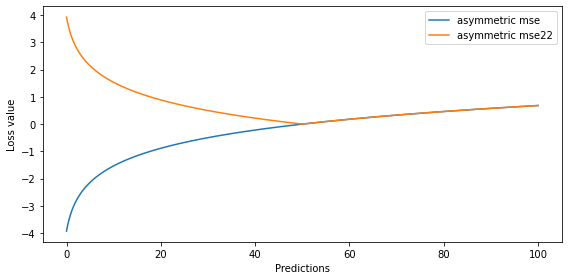

In [210]:
# let's see how our custom loss function looks with respect to different prediction values

y_true = np.repeat(50,1000)
y_pred = np.linspace(0,100,1000)
residual = (y_true - y_pred).astype("float")

custom_loss = np.log(((y_pred)+1) )-np.log(y_true + 1)
# custom_loss = np.log1p(y_pred) - np.log1p(y_true)
custom_loss2 =  [root_mean_squared_log_error(np.array([50]),np.array([p])) for p in list(y_pred)]

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(y_pred, custom_loss, alpha=1, label="asymmetric mse")

sns.lineplot(y_pred, custom_loss2, alpha=1, label="asymmetric mse22")

ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")

fig.tight_layout()
# custom_loss2

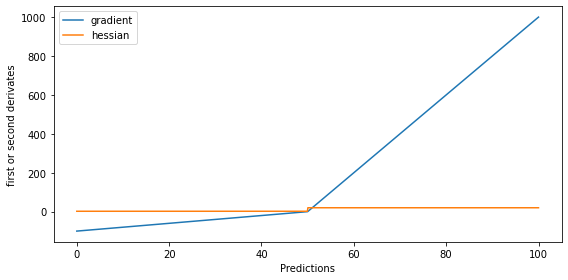

In [211]:
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

# Apply metric to lgbm

In [216]:
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

# gbm6.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm6.fit(
    X_train,
    np.log(y_train),
    eval_set=[(X_test, np.log(y_test))],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


LGBMRegressor(early_stopping_rounds=10, n_estimators=10000, random_state=33)

In [217]:
lgbm_prediction = np.exp(gbm6.predict(X_test))
lgbm_rmsle = root_mean_squared_log_error(lgbm_prediction, y_test)
print('LGBM RMSLE:', lgbm_rmsle)

XGBoost RMSLE: 0.12217083807945368


Text(0, 0.5, 'Ground Truth')

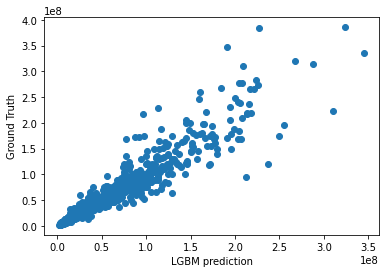

In [219]:
plt.scatter(lgbm_prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

## Submission lgbm

In [220]:
lgb_prediction = np.exp(gbm6.predict(test_labels))
df = pd.DataFrame(lgb_prediction, columns = ['price_prediction'])
test.rename(columns={'apartment_id' : 'id'}, inplace=True)
result = pd.concat([test['id'], df], axis=1)
result = result.sort_values(by='id')
result[['id','price_prediction']].to_csv('.\submissions\LGBM2.0.csv', index=False)